# DOA and Beamforming
in this section we will compare between the DOA methods. the steps will be:
1. Create a phased array with 4 antennas that get at the most 3 signals.
2. Create utilizers function for the methods such as autocorrelation function and extracting the eigenvector subspaces.  
3. create the 3 methods.
4. ploting all methods


# import all nesseccery libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import firwin, lfilter
from scipy.io import loadmat
from scipy.interpolate import CubicSpline
import os
from sklearn.metrics import mean_squared_error

# phased array and producing R


the arrivale of one signal:

Class for Phased array:
- assuming isotropic antennas
- Init(ant_num, dist_between_ant, wave_lambda) - in meter units

In [2]:
class PhasedArray:
    def __init__(self, ant_num, dist_between_ant, wave_lambda):
        self.mAntNum = ant_num
        self.mDistBetweenAnt = dist_between_ant
        self.mLambda = wave_lambda

    def GetSamples(self, inVec0, theta0, inVec1 = None, theta1 = None):
        outMatrix = []
        theta0 = np.deg2rad(theta0)
        phasesVec0 = np.exp(2j * np.sin(theta0) * self.mDistBetweenAnt * np.pi * np.arange(self.mAntNum) / self.mLambda)
        outMatrix = phasesVec0[:, np.newaxis] * inVec0[np.newaxis, :]
        if inVec1 is not None and theta1 is not None:
            theta1 = np.deg2rad(theta1)
            phasesVec1 = np.exp(2j * np.sin(theta1) * self.mDistBetweenAnt * np.pi * np.arange(self.mAntNum) / self.mLambda)
            outMatrix += phasesVec1[:, np.newaxis] * inVec1[np.newaxis, :]
        return(outMatrix)


producing R

In [3]:
class RCalculator:
    def __init__(self, antenna_number, mode, alpha = 0.5):
        self.mAntNum = antenna_number
        self.mR = np.zeros((self.mAntNum, self.mAntNum))
        self.mAlpha = alpha
        self.mMode = mode
        if mode == "alpha filter":
          if self.mAlpha > 1 or self.mAlpha < 0:
              print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxX")
              print("R calculator - Alpha must be less then 1 and more then 0 !!")
              print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxX")
              exit()
        elif mode != "avarage":
              print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxX")
              print("R calculator - mode is not valid -> choose alpha filter or avarage !!")
              print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxX")
              exit()

    def GetSamples(self, inMatrix):
        if self.mMode == "alpha filter":
          for i in range(inMatrix.shape[1]):
              lastSampVec = inMatrix[:,i].reshape(inMatrix.shape[0], 1)
              R = lastSampVec @ lastSampVec.conj().T
              self.mR = (1 - self.mAlpha) * self.mR + self.mAlpha * R
        else:
              self.mR = np.dot(inMatrix, inMatrix.conj().T) / inMatrix.shape[1]
        return self.mR


# DOA algorithms

## Delay-and-Sum algorithm (beam scan)

In [4]:
class DS:
  def __init__(self, ant_num, dist_between_ant, wave_lambda):
    self.mAntNum = ant_num
    self.mDistBetweenAnt = dist_between_ant
    self.mLambda = wave_lambda

  def GetSamples(self, R, D_obj, scanAnglesDeg=np.arange(-90, 91, 1)):

    ant_indices = np.arange(self.mAntNum).reshape(-1, 1)  # shape (N, 1) N= number of antennas
    power = []
    for theta in scanAnglesDeg:
        #calibration
        D = D_obj.GetD(theta)
        D_inv = np.linalg.inv(D)
        D_inv_conj_H = np.conj(D_inv).T
        #steering Vector
        sin_theta= np.sin(np.deg2rad(theta)) #scalar
        phase_shifts= 2j * np.pi * (self.mDistBetweenAnt / self.mLambda) * ant_indices * sin_theta # shape (1, N)
        W = np.exp(phase_shifts) # shape (N, 1)
        #correct R
        R_transformed = D_inv_conj_H @ R @ D_inv # shape (N, N)
        #apply algorithem
        power.append(((W.conj().T @ R_transformed @ W).item() + 1e-6)) # (1,N)@(N,N)@(N,1)
    power = np.abs(power)
    power /= np.max(power)
    power_db =  10 * np.log10(np.abs(power) + 1e-6)
    return scanAnglesDeg, power_db


  def PlotTheResult(self,results, theta_scan):
    plt.plot(theta_scan * 180 / np.pi, results) # lets plot angle in degrees
    plt.xlabel("Theta [Degrees]")
    plt.ylabel("DOA Metric")
    plt.grid()
    plt.show()



## MVDR algorithm

In [5]:
class MVDR:
  def __init__(self, ant_num, dist_between_ant, wave_lambda):
    self.mAntNum = ant_num
    self.mDistBetweenAnt = dist_between_ant
    self.mLambda = wave_lambda

  def GetSamples(self, R, D_obj, scanAnglesDeg=np.arange(-90, 91, 1)):

    ant_indices = np.arange(self.mAntNum).reshape(-1, 1)  # shape (N, 1) N= number of antennas
    power = []
    for theta in scanAnglesDeg:
        #calibration
        D = D_obj.GetD(theta)
        D_inv = np.linalg.inv(D)
        D_inv_conj_H = np.conj(D_inv).T
        #steering Vector
        sin_theta= np.sin(np.deg2rad(theta)) #scalar
        phase_shifts= 2j * np.pi * (self.mDistBetweenAnt / self.mLambda) * ant_indices * sin_theta # shape (1, N)
        W = np.exp(phase_shifts) # shape (N, 1)
        #correct R
        R_transformed = D_inv_conj_H @ R @ D_inv # shape (N, N)
        R_inv= np.linalg.inv(R_transformed)
        #apply algorithem
        power.append(1.0 / ((W.conj().T @ R_inv @ W).item() + 1e-6)) # (1,N)@(N,N)@(N,1)
    power = np.abs(power)
    power /= np.max(power)
    power_db =  10 * np.log10(np.abs(power) + 1e-6)
    return scanAnglesDeg, power_db

  def PlotTheResult(self,results, theta_scan):
    plt.plot(theta_scan* 180 / np.pi, results) # lets plot angle in degrees
    plt.xlabel("Theta [Degrees]")
    plt.ylabel("DOA Metric")
    plt.grid()
    plt.show()



## MUSIC algorithm


In [6]:
class MusicDoa:
    def __init__(self, ant_num, dist_between_ant, wave_lambda):
        self.mNumberOfAntennas = ant_num
        self.mDistBetweenAnt = dist_between_ant
        self.mLambda = wave_lambda
        self.mPower = None
        self.mAngles = None

    def GetSamples(self, R,  D_obj, scanAnglesDeg=np.arange(-90, 91, 1), signal_count=1):
        angles = scanAnglesDeg
        power = []
        for theta_deg in angles:
            D = D_obj.GetD(theta_deg)
            D_inv = np.linalg.inv(D)
            D_inv_conj_H = np.conj(D_inv).T
            R_transformed = D_inv_conj_H @ R @ D_inv
            eigvals, eigvecs = np.linalg.eigh(R_transformed)
            noise_eigvecs = eigvecs[:, :-signal_count]  #vectors with the smallest eigen valuse
            theta = np.deg2rad(theta_deg)
            steering_vec = np.exp(2j * np.pi * self.mDistBetweenAnt * np.sin(theta) * np.arange(self.mNumberOfAntennas) / self.mLambda).reshape(-1, 1)#FIX- arrange of antenna can be created once and sin can take only radians
            power.append(1.0 / np.linalg.norm(np.dot(noise_eigvecs.conj().T, steering_vec))**2)
        power = np.abs(power)
        power /= np.max(power)
        power_db = 10 * np.log(power + 1e-6)
        self.mPower = power_db
        self.mAngles = angles
        return angles, power_db

    def PlotPower(self):
        plt.plot(self.mAngles, self.mPower)
        plt.xlabel("Theta [Degrees]")
        plt.ylabel("DOA power calculation")
        plt.grid()
        plt.show()

## MDL - For recieved signls count estimation

In [7]:
class MdlForSigCnt:
    def __init__(self, ant_num, snapshots_for_r_calc,regulationPower):
        self.mAntNum = ant_num
        self.mSnapForRCalc = snapshots_for_r_calc
        self.mregulationPower=regulationPower


    def GetSamples(self, R):
        eigvals, eigvecs = np.linalg.eigh(R)
        eigvals = np.flip(np.sort(eigvals))                          #flip to decent order
        MdlVal = np.zeros(self.mAntNum - 1)
        for sig_vec_num in range(self.mAntNum - 1):
            noise_eigvals = eigvals[sig_vec_num:]
            gm = np.prod(noise_eigvals) ** (1 / len(noise_eigvals))  # geometric mean
            am = np.mean(noise_eigvals)                              # arithmetic mean
            if gm <= 0 or am <= 0:
                MdlVal[sig_vec_num] = np.inf
            else:
                regulation = 0.5 * sig_vec_num * (2 * self.mAntNum - sig_vec_num) * np.log(self.mSnapForRCalc)
                data_term = -self.mSnapForRCalc * (self.mAntNum - sig_vec_num) * np.log(gm / am)
                MdlVal[sig_vec_num] =  data_term + regulation*self.mregulationPower
        EstSigVecsCnt = np.argmin(MdlVal)

        if EstSigVecsCnt == 0:
            print("OoOoOoOoOoOoOoOoOoOoOoOoOoOoOoOoOoOo")
            print("MDL - estimated signal count is 0")
            print("OoOoOoOoOoOoOoOoOoOoOoOoOoOoOoOoOoOo")
            exit()

        return EstSigVecsCnt

#Calibration functions

## phase and gain calculation

In [8]:
def cphase(rawData,theta,wave_length,distance,num_of_antennas,reference_ant):
    """
    Calibrates phases using FFT phase estimation.

    Parameters:
    rawData (ndarray): n x 4 raw signal matrix (complex)
    reference_ant (int): Index of the reference antenna (0-based)

    Returns:
    fixed_rawData (ndarray): n x 4 phase-aligned signal matrix
    weights (ndarray): 4 x 1 vector of complex weights for phase alignment
    """
    if not isinstance(rawData, np.ndarray) or not isinstance(reference_ant, int):
        print("XxXxXxXxXxXxXxXxXxXxXx")
        print("rawData must be a matrix and reference_ant an integer")
        print("XxXxXxXxXxXxXxXxXxXxXx")
        exit()

    max_val = np.zeros(4, dtype=complex) # (0,0,0,0)

    # FFT and find the max in frequency domain
    for i in range(4):
        rawFt = np.fft.fftshift(np.fft.fft(rawData[:, i]))
        max_val[i] = rawFt[np.argmax(np.abs(rawFt))]

    angs = np.angle(max_val) #shape (4,) - 1 D
    ant_indices = np.arange(num_of_antennas) # (0,1,2,3) shape (4,) - 1 D
    steering_vector= (2*np.pi* ant_indices * (distance/wave_length))*np.sin(np.deg2rad(theta))
    cal_angs= angs- steering_vector #shape (4,) - 1 D
    cal_angs= cal_angs- angs[reference_ant]
    weights = np.exp(-1j * cal_angs)
    fixed_rawData = rawData * weights  # broadcasting applies each weight column-wise
    return weights, fixed_rawData

def cgain(rawData, reference_ant):
    """
    Calibrates Gain using norm.

    Parameters:
    rawData (ndarray): n x 4 raw signal matrix (complex)
    reference_ant (int): Index of the reference antenna (0-based)

    Returns:
    fixed_rawData (ndarray): n x 4 phase-aligned signal matrix
    gain_mismatch (ndarray): 4 x 1 vector of gain weights
    """
    if not isinstance(rawData, np.ndarray) or not isinstance(reference_ant, int):
        print("XxXxXxXxXxXxXxXxXxXxXx")
        print("rawData must be a matrix and reference_ant an integer")
        print("XxXxXxXxXxXxXxXxXxXxXx")
        exit()

    N = rawData.shape[0]  # number of time samples
    norm_val= np.zeros(4)
    for i in range(4):
        antennaData=rawData[:,i]
        norm_val[i] = np.linalg.norm(antennaData)  # Frobenius norm (L2 over elements i)
    #FIX- If theta is 0 return it and devide all with the first antenna gain
    gain_mismatch = (norm_val / np.sqrt(N))
    gain_mismatch= gain_mismatch / gain_mismatch[reference_ant]  # FIX- maybe?
    fixed_rawData= rawData * gain_mismatch
    #gain_mismatch= np.zeros(4, dtype=complex)
    return gain_mismatch, fixed_rawData

## Build D

In [9]:
def D_Builder(DicOfRawData, maxAngel=60, resolution=10 ,distance=0.5*(3e8 / 28e9),wave_length=3e8 / 28e9 ,num_of_antennas=4, reference_ant=0):
    """
    bulding D depends on the given data from each degree.

    Parameters:
    arrayOfRawData (ndarray): m x n x 4 raw signal matrix (complex) where
        -m is for the rawData from specific theta and n is the number of sampling
        -n is the number of sampling
        -4 is the number of antennas
    reference_ant (int): Index of the reference antenna (0-based)

    Returns:
    dictionary with D matrix arrays 4 x 4: m degrees and each one has 4 x 4 GP mismtach
    """
    D_MatrixDic= {}
    theta = -maxAngel

    # #start with theta 0
    # rawData= DicOfRawData[0]
    # # get the mismatch
    # gain_mismatch, _= cgain(rawData,reference_ant) #shape of (4,)
    # gain_mismatch_zero= gain_mismatch[0]
    # phase_mismatch, _= cphase(rawData=rawData,theta=0,wave_length=wave_length,distance=distance,num_of_antennas=num_of_antennas,reference_ant=reference_ant) #shape of (4,)
    # #make them diagonal
    # gain_diag= np.diag(gain_mismatch / (gain_mismatch_zero + 1e-12)) #shape of 4x4
    # phase_diag= np.diag(phase_mismatch) #shape of 4x4
    # #calculate D
    # D= gain_diag @ phase_diag #shape of 4x4
    # #insert it to dictionary
    # D_MatrixDic[0]= D



    for i in DicOfRawData:
      # if (theta == 0):
      #   continue
      rawData= DicOfRawData[theta]
      # ~~~~~~~ get the mismatch ~~~~~~~
      gain_mismatch, _= cgain(rawData,reference_ant) #shape of (4,)
      phase_mismatch, _= cphase(rawData=rawData,theta=theta,wave_length=wave_length,distance=distance,num_of_antennas=num_of_antennas,reference_ant=reference_ant) #shape of (4,)
      #  ~~~~~~~  make them diagonal ~~~~~~~
      # gain_diag= np.diag(gain_mismatch / (gain_mismatch_zero + 1e-12)) #shape of 4x4
      gain_diag= np.diag(gain_mismatch) #shape of 4x4
      phase_diag= np.diag(phase_mismatch) #shape of 4x4
      #  ~~~~~~~  calculate D ~~~~~~~
      D= gain_diag @ phase_diag #shape of 4x4
      #  ~~~~~~~ insert it to dictionary ~~~~~~~
      D_MatrixDic[theta]= D
      theta += resolution

    return D_MatrixDic

##D_creator

In [10]:
class D_creator:
    def __init__(self, ant_num, max_angle, resolution = 0.5, mode = "CubicSpline"):
        self.mD = {}
        self.mAntNum = ant_num
        self.mMaxAngle = max_angle
        self.mResolution = resolution
        self.mInterpulationMode = mode
        self.mInterpulationDone = False

    def GetSample(self, D, angle):
        if D.shape[0] != self.mAntNum | D.shape[1] != self.mAntNum:
            print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
            print("D - D shape is not aligned to the antennas number!")
            print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
            exit()
        self.mD[angle] = D

    def Interpulate(self):
        if self.mInterpulationMode == "ZOH":
            angles = np.arange(-self.mMaxAngle, self.mMaxAngle, self.mResolution)
            tmpDict = {}
            for angle in angles:
                tmpDict[angle] = self.GetClosestD(angle)
            self.mD = tmpDict
        elif self.mInterpulationMode == "CubicSpline":
            original_angles = sorted(self.mD.keys())

            # Prepare interpolators for each diagonal element
            real_splines = []
            imag_splines = []
            for i in range(self.mAntNum):
                real_vals = [np.real(self.mD[angle][i, i]) for angle in original_angles]
                imag_vals = [np.imag(self.mD[angle][i, i]) for angle in original_angles]
                real_splines.append(CubicSpline(original_angles, real_vals))
                imag_splines.append(CubicSpline(original_angles, imag_vals))

            # Interpolate over the full range
            new_angles = np.arange(-self.mMaxAngle, self.mMaxAngle + self.mResolution, self.mResolution)
            tmpDict = {}
            for angle in new_angles:
                D_interp = np.zeros((self.mAntNum, self.mAntNum), dtype=complex)
                for i in range(self.mAntNum):
                    real_val = real_splines[i](angle)
                    imag_val = imag_splines[i](angle)
                    D_interp[i, i] = real_val + 1j * imag_val
                tmpDict[np.round(angle, 6)] = D_interp  # Round key for stability
        else:
            print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
            print("D - Interpulation mode is not valid -> chose ZOH or CubicSpline!")
            print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
            exit()
        self.mD = tmpDict
        self.mInterpulationDone = True

    def GetClosestD(self, angle):
        closest = None
        minDist = np.inf
        for key in self.mD.keys():
            dist = np.abs(angle - key)
            if dist < minDist:
                minDist = dist
                closest = key
        return self.mD[closest]

    def GetD(self, angle):
        if self.mInterpulationDone == False:
            print("XxXxXxXxXxXxXxXxXxXxXx")
            print("D - Interpulate first!")
            print("XxXxXxXxXxXxXxXxXxXxXx")
            exit()
        if np.abs(angle) > self.mMaxAngle:
            print("0000000000000000000000000000000000000000000000000000000000000")
            print("D - Angle is not valid -> max angle is " + str(self.mMaxAngle))
            print("0000000000000000000000000000000000000000000000000000000000000")
            angle = np.clip(angle, -self.mMaxAngle, self.mMaxAngle)
        res = angle % self.mResolution
        key = angle - res
        return(self.mD[key])

    def PlotGainMismatch(self, maxAngle):
      scanAngles = np.arange(-maxAngle, maxAngle + 1)
      element_0 = []
      element_1 = []
      element_2 = []
      element_3 = [] #Jump here
      for theta in scanAngles:
        theta = int(theta)
        matrix=self.mD[theta]
        element_0.append(np.abs(matrix[0,0]))
        element_1.append(np.abs(matrix[1,1]))
        element_2.append(np.abs(matrix[2,2]))
        element_3.append(np.abs(matrix[3,3]))
      # Plotting
      plt.figure(figsize=(10, 6))
      plt.plot(scanAngles, element_0, label='Element 0')
      plt.plot(scanAngles, element_1, label='Element 1')
      plt.plot(scanAngles, element_2, label='Element 2')
      plt.plot(scanAngles, element_3, label='Element 3')
      plt.xlabel("Scan Angle (degrees)")
      plt.ylabel("Gain Mismatch (abs of diag element)")
      plt.title("Gain Mismatch vs Scan Angle")
      plt.grid(True)
      plt.legend()
      plt.tight_layout()
      plt.show()

    def PlotPhaseMismatch(self, maxAngle):
      scanAngles = np.arange(-maxAngle, maxAngle + 1)
      element_0 = []
      element_1 = []
      element_2 = []
      element_3 = []
      for theta in scanAngles:
        theta = int(theta)
        matrix=self.mD[theta]
        element_0.append(np.angle(matrix[0,0]))
        element_1.append(np.angle(matrix[1,1]))
        element_2.append(np.angle(matrix[2,2]))
        element_3.append(np.angle(matrix[3,3]))
      # Plotting
      plt.figure(figsize=(10, 6))
      plt.plot(scanAngles, element_0, label='Element 0')
      plt.plot(scanAngles, element_1, label='Element 1')
      plt.plot(scanAngles, element_2, label='Element 2')
      plt.plot(scanAngles, element_3, label='Element 3')
      plt.xlabel("Scan Angle (degrees)")
      plt.ylabel("Phase Mismatch (angles of diag element)")
      plt.title("Phase Mismatch vs Scan Angle")
      plt.grid(True)
      plt.legend()
      plt.tight_layout()
      plt.show()

## Create calibrtion matrix function for test banch use

In [11]:
def GetCalibrationMatrix(ant_num, DicOfRawData ,maxAngel, resolution_cal=10,resolution_theta=1, reference_ant=0):
    #build D with the given raw data array
    D_matrix_of_m_thetas= D_Builder(DicOfRawData=DicOfRawData,maxAngel=maxAngel, resolution=resolution_cal, reference_ant=reference_ant)
    #create the object
    D = D_creator(ant_num=ant_num, max_angle=maxAngel, resolution = resolution_theta)
    #enter all the sampling
    for angle, matrix in D_matrix_of_m_thetas.items():
        D.GetSample(matrix,angle)
    #preform the intarpulatin
    D.Interpulate()
    return D

# Support classes

### Peaks finder

In [12]:
class PeaksFinder:

    def __init__(self, peaks_num):
        self.mPeaksNum = peaks_num
        if self.mPeaksNum < 1:
            print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
            print("Peaks finder - Enter at least one peak to find !!!")
            print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
            exit()

    def GetSamples(self, power_values, scanAnglesDeg):
        peaksIdx = find_peaks(np.squeeze(power_values))[0]
        if len(peaksIdx) == 0:
            print("000000000000000000000000000000000000000000")
            print("Peaks finder - No maximum points found !!!")
            print("000000000000000000000000000000000000000000")
        if self.mPeaksNum > len(peaksIdx):
            print("000000000000000000000000000000000000000000000000000")
            print("Peaks finder - Didnt found anoth maximum points !!!")
            print("000000000000000000000000000000000000000000000000000")
        peaksPowers = power_values[peaksIdx]
        sortedIndices = np.argsort(peaksPowers)[::-1]
        topPeaksIdx = peaksIdx[sortedIndices[:self.mPeaksNum]]
        topAngles = scanAnglesDeg[topPeaksIdx.tolist()]

        # ~~~~ If error - return -200 (for kalmans override) ~~~~ #
        if len(topAngles) < self.mPeaksNum:
            topAngles = list(topAngles) + [-200] * (self.mPeaksNum - len(topAngles))
        if self.mPeaksNum == 1:
            return topAngles[0]
        else:
            return topAngles

# Kalman Filter



### Linear Kalman Filter (LKF)

In [13]:
class LKF:
    def __init__(self, init_pos, init_vel, init_var, measurments_var, proccess_variance):
        self.mX = np.array([[init_pos],
                            [init_vel]])
        self.mP = np.array([[init_var, 0],
                            [0, init_var]])
        self.mR = np.array([[measurments_var]])
        self.mQ = proccess_variance * np.eye(2)

    def GetSampels(self, input, dt):
        if isinstance(input, np.ndarray):
          outVec = []
          outVarVec = []
          for sample in input:
              if -91 < sample < 91:
                  pos, var = self.ApplyFilter(sample, dt)
              else:
                  pos, var = self.Override(dt)
              outVec.append(pos)
              outVarVec.append(var)
          return np.array(outVec), np.array(outVarVec)
        else:
          if -91 < input < 91:
              pos, var = self.ApplyFilter(input, dt)
          else:
              pos, var = self.Override(dt)
          return pos, var

    def Override(self, dt):
        F = np.array([[1, dt],
                      [0, 1]])
        H = np.array([[1, 0]])
        I = np.eye(2)

        # --- Prediction only ---
        self.mX = F @ self.mX
        self.mP = F @ self.mP @ F.T + self.mQ

        return self.mX[0, 0], self.mP[0, 0]

    def ApplyFilter(self, measuredPos, dt):
        F = np.array([[1, dt],
                      [0, 1]])
        H = np.array([[1, 0]])
        I = np.eye(2)

        # --- Prediction ---
        self.mX = F @ self.mX
        self.mP = F @ self.mP @ F.T + self.mQ

        # --- Update ---
        z = np.array([[measuredPos]])
        y = z - H @ self.mX
        S = H @ self.mP @ H.T + self.mR
        K = self.mP @ H.T @ np.linalg.inv(S)

        # --- Estimation ---
        self.mX = self.mX + K @ y
        self.mP = (I - K @ H) @ self.mP

        return self.mX[0, 0], self.mP[0, 0]

### Extanded Kalman Filter (EKF)
For oscilator tracking

In [14]:
class EKF:
    def __init__(self, init_angle, init_angularVelocity,init_Omega, init_var, measurments_var, proccess_variance):
        self.mX = np.array([[init_angle],
                            [init_angularVelocity],
                            [init_Omega]])
        self.mP = init_var * np.eye(3)
        self.mR =   np.array([[measurments_var]])
        self.mQ = proccess_variance * np.eye(3)
        self.mH =np.array([[1,0,0]])
        self.mI= np.eye(3)

    def GetSampels(self, input, dt):
        if isinstance(input, np.ndarray):
          outVec = []
          outVarVec = []
          for sample in input:
              if -91 < sample < 91:
                  pos, var = self.ApplyFilter(sample, dt)
              else:
                  pos, var = self.Override(dt)
              outVec.append(pos)
              outVarVec.append(var)
          return np.array(outVec), np.array(outVarVec)
        else:
          if -91 < input < 91:
              pos, var = self.ApplyFilter(input, dt)
          else:
              pos, var = self.Override(dt)
          return pos, var

    def Override(self, dt):
        new_theat= self.mX[0,0]+ dt*self.mX[1,0]
        new_theta_dot= self.mX[1,0] - dt*self.mX[0,0]*self.mX[2,0] ** 2
        new_omega = self.mX[2,0]

        F_Jacobian = np.array([[1, dt,0],
                               [-(self.mX[2,0]**2) * dt, 1, -2* self.mX[2,0] * self.mX[0,0] * dt],
                               [0, 0, 1]])

        # --- Prediction only ---
        self.mX = np.array([[new_theat],
                    [new_theta_dot],
                    [new_omega]])
        self.mP = F_Jacobian @ self.mP @ F_Jacobian.T + self.mQ

        return self.mX[0, 0], self.mP[0, 0]


    def ApplyFilter(self, measuredPos, dt):
        #calculate f(x_(n,n)) because it is not linear and we can not write it as a matrix
        new_theat= self.mX[0,0]+ dt*self.mX[1,0]
        new_theta_dot= self.mX[1,0] - dt*self.mX[0,0]*self.mX[2,0] ** 2
        new_omega = self.mX[2,0]

        F_Jacobian = np.array([[1, dt,0],
                               [-(self.mX[2,0]**2) * dt, 1, -2* self.mX[2,0] * self.mX[0,0] * dt],
                               [0, 0, 1]])


        # --- Prediction ---
        self.mX = np.array([[new_theat],
                    [new_theta_dot],
                    [new_omega]])
        self.mP = F_Jacobian @ self.mP @ F_Jacobian.T + self.mQ

        #-----Kalman Update-------
        K= self.mP @ self.mH.T @ np.linalg.inv( self.mH @ self.mP @ self.mH.T+ self.mR)

        # --- Update ---
        z = np.array([[measuredPos]])
        self.mX= self.mX + K @ (z-self.mH@ self.mX)
        self.mP = (self.mI - K @ self.mH) @ self.mP

        return self.mX[0, 0], self.mP[0, 0]



###UAV class
moving object with linear nd ocsilator modes

In [15]:
class UAV:
  def __init__(self, starting_point=0,left_side=-10,right_side=10):
    self.mStartingPoint=starting_point
    self.mLeftSide=left_side
    self.mRightSide= right_side

  def OscillatorMovment(self,omega=1,range=20,durationTime=60,numberOfPointsToMeasure=121): #Samplee rate + range to amplitude and cemnter
    time=np.linspace(0,durationTime,numberOfPointsToMeasure)
    UAV_position_results=[]
    UAV_Postition=0
    for t in time:
      UAV_Postition = self.mStartingPoint +range*np.sin(omega*t)
      UAV_position_results.append(float(UAV_Postition))
    return UAV_position_results
  def StraightMovment(self,velocity=1,durationTime=20,numberOfPointsToMeasure=21):
      time=np.linspace(0,durationTime,numberOfPointsToMeasure)
      UAV_position_results=[]
      UAV_Postition=0
      for i in range(1, len(time)):
          delta_t = time[i] - time[i - 1]
          UAV_Postition += velocity*delta_t
          UAV_position_results.append(float(UAV_Postition))
      return UAV_position_results
  def ColumnMoveOscilatory(self,hight,K,windForce,durationTime=60,numberOfPointsToMeasure=121):
    return



# Test Banch

## Test banch functions

In [16]:
def PlotResults(before_kalman, after_kalman, ci, real_position = None, Ts = 1, title = None, y_lim=90):
    if len(before_kalman) != len(after_kalman):
          print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
          print("Plot function - Inputs are not the same langth !!!")
          print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
          exit()
    time = np.arange(len(before_kalman)) / Ts
    plt.figure(figsize=(10, 5))
    plt.plot(before_kalman, linestyle='--', color='red', label='Before Kalman', linewidth=2)
    plt.plot(after_kalman, linestyle='-', color='orange', label='After Kalman', linewidth=2)
    plt.fill_between(time, after_kalman - ci, after_kalman + ci, color='orange', alpha=0.3, label='95% CI')

    if real_position is not None:
        if len(before_kalman) != len(real_position):
              print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
              print("Plot function - Inputs are not the same langth !!!")
              print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
              exit()
        plt.plot(real_position, linestyle='--', color='green', label='Real position', linewidth=2)

    plt.xlabel('Time (s)')
    plt.ylabel('Angle (radians)')
    plt.ylim([-y_lim, y_lim])
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def PlotCompareBetween_LKF_and_EKF(before_kalman, after_kalman_LKF,after_kalman_EKF, ci, real_position = None, Ts = 1, title = None, y_lim=90):
    if ((len(before_kalman) != len(after_kalman_LKF)) | (len(before_kalman) != len(after_kalman_EKF))):
          print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
          print("Plot function - Inputs are not the same langth !!!")
          print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
          exit()
    time = np.arange(len(before_kalman)) / Ts
    plt.figure(figsize=(10, 5))
    plt.plot(before_kalman, linestyle='--', color='red', label='Before Kalman', linewidth=2)
    plt.plot(after_kalman_LKF, linestyle='-', color='orange', label='after Kalman LKF', linewidth=2)
    plt.plot(after_kalman_EKF, linestyle='-', color='blue', label='after Kalman EKF', linewidth=2)

    if real_position is not None:
        if len(before_kalman) != len(real_position):
              print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
              print("Plot function - Inputs are not the same langth !!!")
              print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
              exit()
        plt.plot(real_position, linestyle='--', color='green', label='Real position', linewidth=2)

    plt.xlabel('Time (s)')
    plt.ylabel('Angle (Degrees)')
    plt.ylim([-y_lim, y_lim])
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def GenInputFrames(Data, position_vec ,num_of_samples):
    inputFrames = []
    for pos in position_vec:
        rawData = Data[pos]
        frame = np.array(rawData[:num_of_samples])
        inputFrames.append(frame)
    return inputFrames

## MODEL - using phased array class - LKF

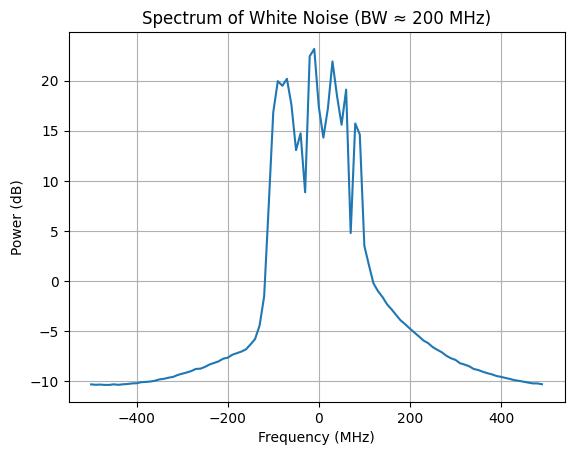

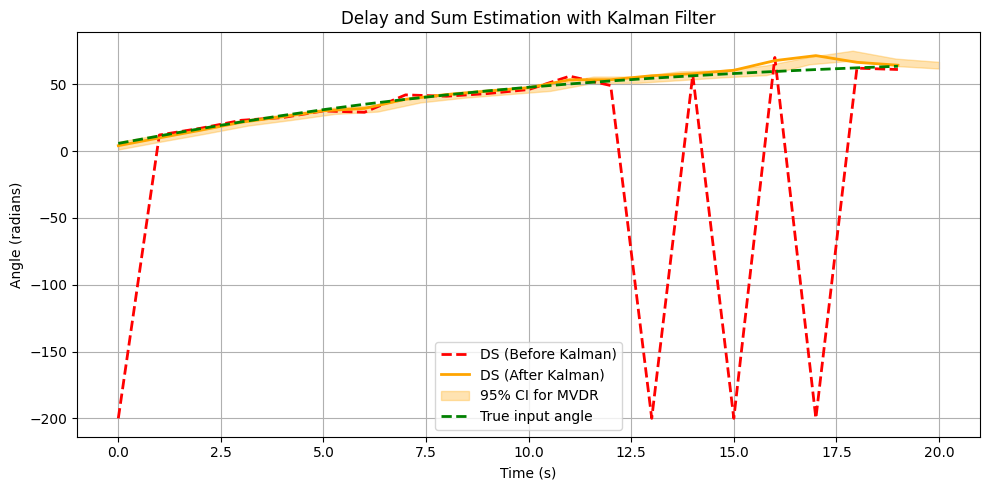

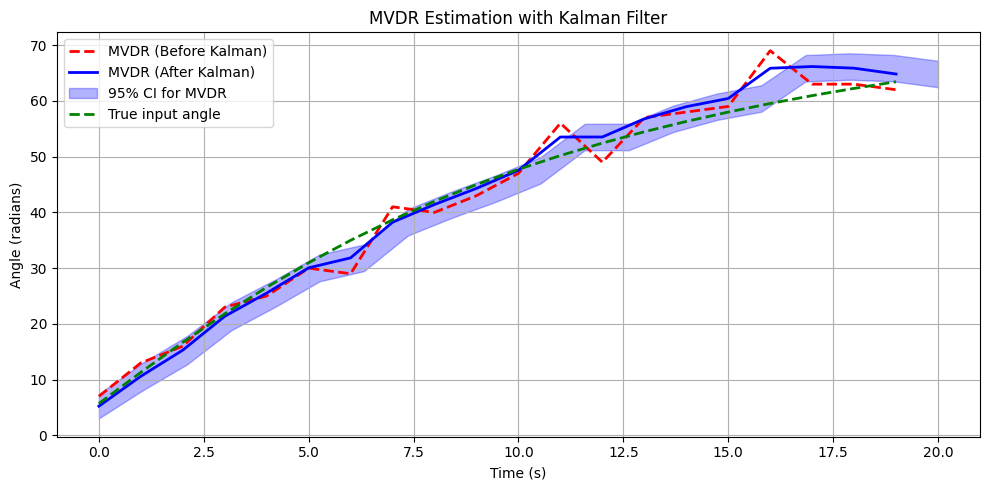

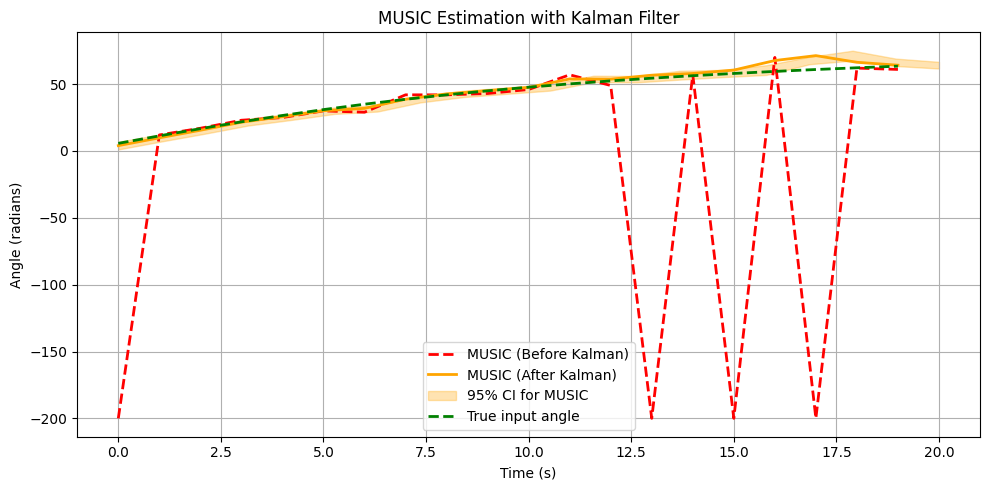

In [17]:
#Simulation parameters
num_antennas = 4
snr = 10
rf_freq = 28e9
sample_freq = 1e9
bw = 200e6
num_of_samples = 20

#System decleration
wavelength = 3e8 / rf_freq
d = wavelength / 2

uav=UAV()
R_Calculator = RCalculator(num_antennas, "alpha filter", 0.1)
D = D_creator(num_antennas, 90, resolution = 1)
pa = PhasedArray(num_antennas, d, wavelength)
Mdl = MdlForSigCnt(num_antennas, num_of_samples,0.4) # chang here
ds= DS(num_antennas, d, wavelength)
mvdr = MVDR(num_antennas, d, wavelength)
music = MusicDoa(num_antennas, d, wavelength)
Kalman_DS = LKF(init_pos=2, init_vel=2, init_var=1, measurments_var=3, proccess_variance=0.12)
Kalman_MVDR = LKF(init_pos=2, init_vel=2, init_var=1, measurments_var=3, proccess_variance=0.12)
Kalman_MUSIC = LKF(init_pos=2, init_vel=2, init_var=1, measurments_var=3, proccess_variance=0.12)

DS_before_kalman = []
DS_after_kalman = []
MVDR_before_kalman = []
MVDR_after_kalman = []
MUSIC_before_kalman = []
MUSIC_after_kalman = []

#moving object
position_linear= uav.StraightMovment()
time_linear= np.linspace(0, 20, num_of_samples)
theta_linear_movment = np.rad2deg(np.arctan(np.array(position_linear) / 10)) #imagine the trget is 10 m away horizontally

#calibration
D.GetSample(np.identity(num_antennas), -10)
D.GetSample(np.identity(num_antennas), 0)
D.GetSample(np.identity(num_antennas), 10)
D.Interpulate()

#Feeding the system with smples
for theta in theta_linear_movment:

    # Generate recieved signal
    num_of_samples = 100
    noise = np.random.normal(0, 1, num_of_samples) + 1j * np.random.normal(0, 1, num_of_samples)
    cutoff = bw / sample_freq  # Normalize cutoff frequency (to Nyquist = fs/2)
    taps = firwin(numtaps=101, cutoff=cutoff, window="hamming")
    signal0 = lfilter(taps, 1.0, noise)
    received_matrix = pa.GetSamples(signal0, theta)
    noise_power = np.sqrt(2) / np.sqrt(snr)
    received_matrix += noise_power * (np.random.randn(*received_matrix.shape) + 1j * np.random.randn(*received_matrix.shape))
    R = R_Calculator.GetSamples(received_matrix)

    # Apply MDL
    sig_cnt = Mdl.GetSamples(R)
    if sig_cnt !=1:
      DS_before_kalman.append(-200)
      # MVDR_before_kalman.append(-200)
      MUSIC_before_kalman.append(-200)
    else:
      #DOA
      angle_ds, power_ds = ds.GetSamples(R, D, scanAnglesDeg=np.arange(-80, 80, 1))
      # angles_mvdr, power_mvdr = mvdr.GetSamples(R, D, scanAnglesDeg=np.arange(-80, 80, 1))
      angles_music, power_music = music.GetSamples(R, D, scanAnglesDeg=np.arange(-80, 80, 1), signal_count=sig_cnt)
      # Extract maximum
      peaksFinder = PeaksFinder(sig_cnt)
      dsPeacks= peaksFinder.GetSamples(power_ds, angle_ds)
      # mvdrPeacks = peaksFinder.GetSamples(power_mvdr, angles_mvdr)
      musicPeacks = peaksFinder.GetSamples(power_music, angles_music)
      DS_before_kalman.append(dsPeacks)
      # MVDR_before_kalman.append(mvdrPeacks)
      MUSIC_before_kalman.append(musicPeacks)

    angles_mvdr, power_mvdr = mvdr.GetSamples(R, D, scanAnglesDeg=np.arange(-80, 80, 1))
    peaksFinder1 = PeaksFinder(1)
    mvdrPeacks = peaksFinder1.GetSamples(power_mvdr, angles_mvdr)
    MVDR_before_kalman.append(mvdrPeacks)


#Applying klman filter
DS_before_kalman= np.squeeze(np.array(DS_before_kalman))
outDS, outVarDs = Kalman_DS.GetSampels(DS_before_kalman, 1)
MVDR_before_kalman = np.squeeze(np.array(MVDR_before_kalman))
outMVDR, outVarMVDR = Kalman_MVDR.GetSampels(MVDR_before_kalman, 1)
MUSIC_before_kalman = np.squeeze(np.array(MUSIC_before_kalman))
outMUSIC, outVarMUSIC = Kalman_MUSIC.GetSampels(MUSIC_before_kalman, 1)

DS_after_kalman = np.squeeze(np.array(outDS))
MVDR_after_kalman = np.squeeze(np.array(outMVDR))
MUSIC_after_kalman = np.squeeze(np.array(outMUSIC))

# --- Convert to NumPy arrays for math ---
DS_after_kalman = np.squeeze(np.array(DS_after_kalman))
MVDR_after_kalman = np.squeeze(np.array(MVDR_after_kalman))
MUSIC_after_kalman = np.squeeze(np.array(MUSIC_after_kalman))

# --- 95% Confidence intervals (±1.96 * std) ---
ciDS= 1.96 * np.sqrt(outVarDs)
ciMVDR = 1.96 * np.sqrt(outVarMVDR)
ciMUSIC = 1.96 * np.sqrt(outVarMUSIC)

# --- Plotting input spectrum ---
freqs = np.fft.fftfreq(len(signal0), d=1/sample_freq)
spectrum = np.fft.fft(signal0)
plt.plot(np.fft.fftshift(freqs)/1e6, 10*np.log10(np.fft.fftshift(np.abs(spectrum)**2)))
plt.title("Spectrum of White Noise (BW ≈ 200 MHz)")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Power (dB)")
plt.grid()
plt.show()

# --- Plotting DS Estimations ---
plt.figure(figsize=(10, 5))
plt.plot(DS_before_kalman, linestyle='--', color='red', label='DS (Before Kalman)', linewidth=2)
plt.plot(DS_after_kalman, linestyle='-', color='orange', label='DS (After Kalman)', linewidth=2)
plt.fill_between(time_linear, DS_after_kalman - ciDS, DS_after_kalman + ciDS, color='orange', alpha=0.3, label='95% CI for MVDR')
plt.plot(theta_linear_movment, linestyle='--', color='green', label='True input angle', linewidth=2)

plt.xlabel('Time (s)')
plt.ylabel('Angle (radians)')
plt.title('Delay and Sum Estimation with Kalman Filter')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# --- Plotting MVDR Estimations ---
plt.figure(figsize=(10, 5))
plt.plot(MVDR_before_kalman, linestyle='--', color='red', label='MVDR (Before Kalman)', linewidth=2)
plt.plot(MVDR_after_kalman, linestyle='-', color='blue', label='MVDR (After Kalman)', linewidth=2)
plt.fill_between(time_linear, MVDR_after_kalman - ciMVDR, MVDR_after_kalman + ciMVDR, color='blue', alpha=0.3, label='95% CI for MVDR')
plt.plot(theta_linear_movment, linestyle='--', color='green', label='True input angle', linewidth=2)

plt.xlabel('Time (s)')
plt.ylabel('Angle (radians)')
plt.title('MVDR Estimation with Kalman Filter')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plotting MUSIC Estimations ---
plt.figure(figsize=(10, 5))
plt.plot(MUSIC_before_kalman, linestyle='--', color='red', label='MUSIC (Before Kalman)', linewidth=2)
plt.plot(MUSIC_after_kalman, linestyle='-', color='orange', label='MUSIC (After Kalman)', linewidth=2)
plt.fill_between(time_linear, MUSIC_after_kalman - ciMUSIC, MUSIC_after_kalman + ciMUSIC, color='orange', alpha=0.3, label='95% CI for MUSIC')
plt.plot(theta_linear_movment, linestyle='--', color='green', label='True input angle', linewidth=2)

plt.xlabel('Time (s)')
plt.ylabel('Angle (radians)')
plt.title('MUSIC Estimation with Kalman Filter')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## MODEL - using phased array class - EKF


OoOoOoOoOoOoOoOoOoOoOoOoOoOoOoOoOoOo
MDL - estimated signal count is 0
OoOoOoOoOoOoOoOoOoOoOoOoOoOoOoOoOoOo
OoOoOoOoOoOoOoOoOoOoOoOoOoOoOoOoOoOo
MDL - estimated signal count is 0
OoOoOoOoOoOoOoOoOoOoOoOoOoOoOoOoOoOo
OoOoOoOoOoOoOoOoOoOoOoOoOoOoOoOoOoOo
MDL - estimated signal count is 0
OoOoOoOoOoOoOoOoOoOoOoOoOoOoOoOoOoOo


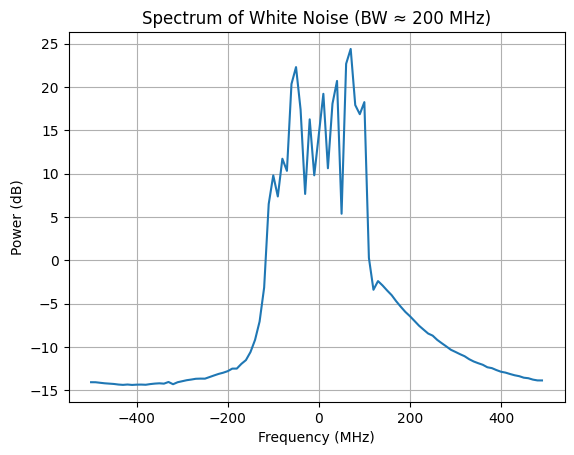

time_linear (21,) DS_before_kalman (21,) DS_after_kalman (21,) theta_oscillator_movment (21,)


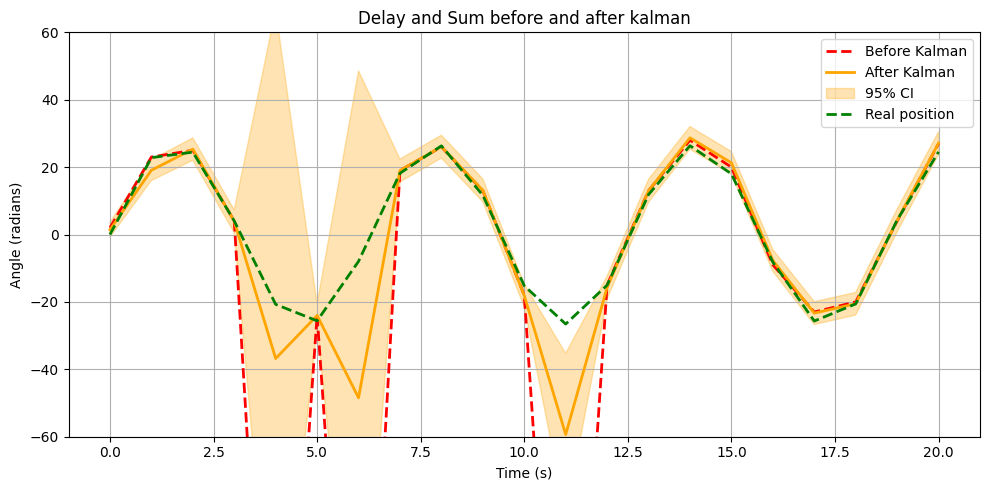

the MSE of DS_before_kalman is: 4720.962735964412 the MSE of DS_after_kalman is: 144.4958625460311


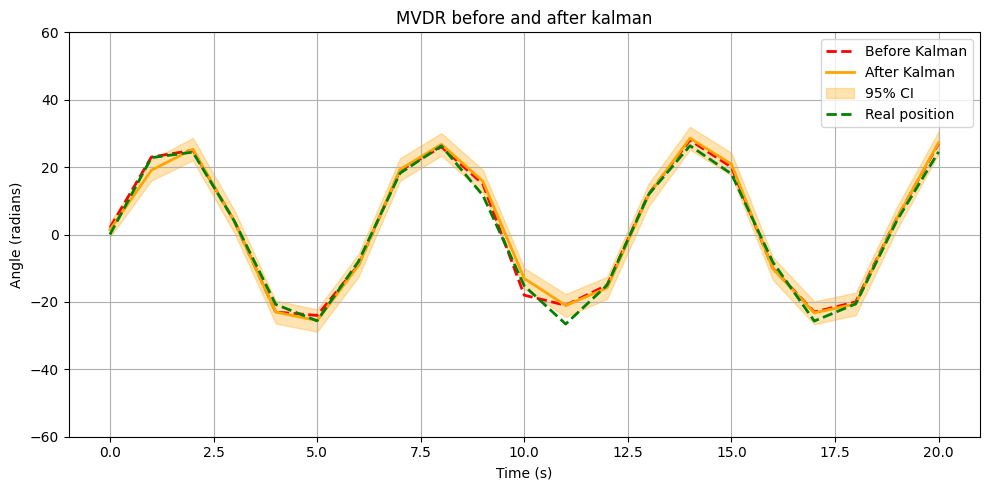

the MSE of MVDR_before_kalman is: 4.190347309942035 the MSE of MVDR_after_kalman is: 5.180864284083777


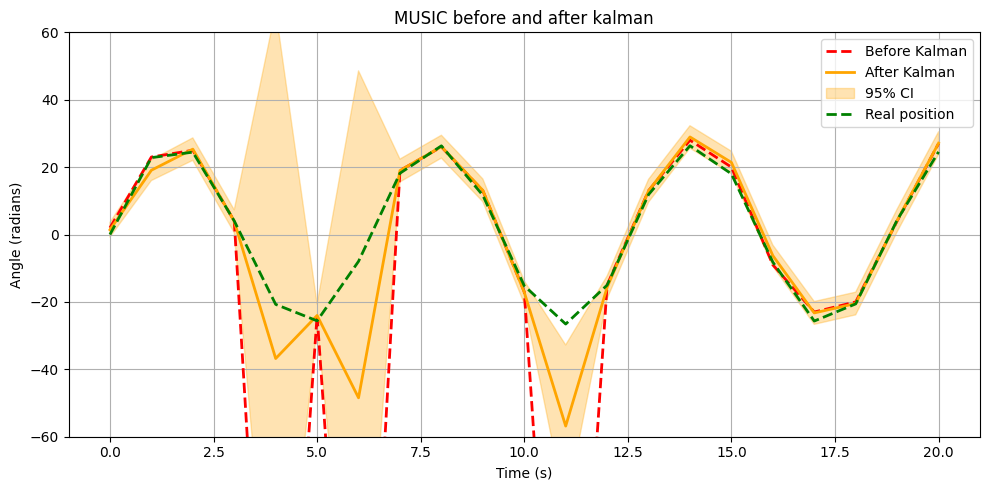

the MSE of MUSIC_before_kalman is: 4720.745296900701 the MSE of MUSIC_after_kalman is: 136.99045979110156


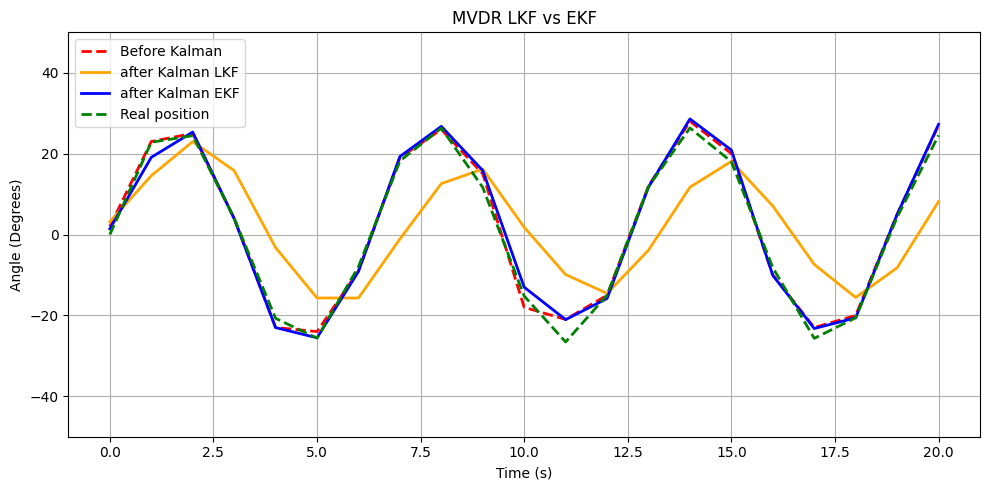

the MSE of MVDR_LKF is: 157.7322400406328 the MSE of MVDR_EKF is: 5.180864284083777


In [18]:
#Simulation parameters
num_antennas = 4
snr = 10
rf_freq = 28e9
sample_freq = 1e9
bw = 200e6
num_of_samples = 21

#System decleration
wavelength = 3e8 / rf_freq
d = wavelength / 2

uav=UAV()
R_Calculator = RCalculator(num_antennas, "alpha filter", 0.1)
D = D_creator(num_antennas, 90, resolution = 1)
pa = PhasedArray(num_antennas, d, wavelength)
Mdl = MdlForSigCnt(num_antennas, num_of_samples,1.5) # chang here
ds= DS(num_antennas, d, wavelength)
mvdr = MVDR(num_antennas, d, wavelength)
music = MusicDoa(num_antennas, d, wavelength)
#EKF
Kalman_DS = EKF(init_angle=0, init_angularVelocity=1,init_Omega=2, init_var=1, measurments_var=3, proccess_variance=0.12)
Kalman_MVDR = EKF(init_angle=0, init_angularVelocity=1,init_Omega=2, init_var=1, measurments_var=3, proccess_variance=0.12)
Kalman_MUSIC = EKF(init_angle=0, init_angularVelocity=1,init_Omega=2, init_var=1, measurments_var=3, proccess_variance=0.12)
#LKF for compare
Kalman_MVDR_LKF = LKF(init_pos=2, init_vel=2, init_var=1, measurments_var=3, proccess_variance=0.12)
MVDR_after_kalman_LKF = []


DS_before_kalman = []
DS_after_kalman = []
MVDR_before_kalman = []
MVDR_after_kalman = []
MUSIC_before_kalman = []
MUSIC_after_kalman = []

#moving object
position_oscillatory= uav.OscillatorMovment(omega=1,range=5,durationTime=20,numberOfPointsToMeasure=21)
time_linear= np.linspace(0, 20, num_of_samples)
theta_oscillator_movment = np.rad2deg(np.arctan(np.array(position_oscillatory) / 10)) #imagine the trget is 10 m away horizontally

#calibration
D.GetSample(np.identity(num_antennas), -10)
D.GetSample(np.identity(num_antennas), 0)
D.GetSample(np.identity(num_antennas), 10)
D.Interpulate()

#Feeding the system with smples
for theta in theta_oscillator_movment:

    # Generate recieved signal
    num_of_samples = 100
    noise = np.random.normal(0, 1, num_of_samples) + 1j * np.random.normal(0, 1, num_of_samples)
    cutoff = bw / sample_freq  # Normalize cutoff frequency (to Nyquist = fs/2)
    taps = firwin(numtaps=101, cutoff=cutoff, window="hamming")
    signal0 = lfilter(taps, 1.0, noise)
    received_matrix = pa.GetSamples(signal0, theta)
    noise_power = np.sqrt(2) / np.sqrt(snr)
    received_matrix += noise_power * (np.random.randn(*received_matrix.shape) + 1j * np.random.randn(*received_matrix.shape))
    R = R_Calculator.GetSamples(received_matrix)

    # Apply MDL
    sig_cnt = Mdl.GetSamples(R)
    if sig_cnt !=1:
      DS_before_kalman.append(-200)
      # MVDR_before_kalman.append(-200)
      MUSIC_before_kalman.append(-200)
    else:
      #DOA
      angle_ds, power_ds = ds.GetSamples(R, D, scanAnglesDeg=np.arange(-80, 80, 1))
      # angles_mvdr, power_mvdr = mvdr.GetSamples(R, D, scanAnglesDeg=np.arange(-80, 80, 1))
      angles_music, power_music = music.GetSamples(R, D, scanAnglesDeg=np.arange(-80, 80, 1), signal_count=sig_cnt)
      # Extract maximum
      peaksFinder = PeaksFinder(sig_cnt)
      dsPeacks= peaksFinder.GetSamples(power_ds, angle_ds)
      # mvdrPeacks = peaksFinder.GetSamples(power_mvdr, angles_mvdr)
      musicPeacks = peaksFinder.GetSamples(power_music, angles_music)
      DS_before_kalman.append(dsPeacks)
      # MVDR_before_kalman.append(mvdrPeacks)
      MUSIC_before_kalman.append(musicPeacks)

    angles_mvdr, power_mvdr = mvdr.GetSamples(R, D, scanAnglesDeg=np.arange(-80, 80, 1))
    peaksFinder1 = PeaksFinder(1)
    mvdrPeacks = peaksFinder1.GetSamples(power_mvdr, angles_mvdr)
    MVDR_before_kalman.append(mvdrPeacks)


#Applying klman filter on EKF
DS_before_kalman= np.squeeze(np.array(DS_before_kalman))
outDS, outVarDs = Kalman_DS.GetSampels(DS_before_kalman, 1)
MVDR_before_kalman = np.squeeze(np.array(MVDR_before_kalman))
outMVDR, outVarMVDR = Kalman_MVDR.GetSampels(MVDR_before_kalman, 1)
MUSIC_before_kalman = np.squeeze(np.array(MUSIC_before_kalman))
outMUSIC, outVarMUSIC = Kalman_MUSIC.GetSampels(MUSIC_before_kalman, 1)

DS_after_kalman = np.squeeze(np.array(outDS))
MVDR_after_kalman = np.squeeze(np.array(outMVDR))
MUSIC_after_kalman = np.squeeze(np.array(outMUSIC))

#Applying klman filter on LKF
outMVDR_LKF, outVarMVDR_LKF = Kalman_MVDR_LKF.GetSampels(MVDR_before_kalman, 1)
MVDR_after_kalman_LKF = np.squeeze(np.array(outMVDR_LKF))

# --- Convert to NumPy arrays for math ---
DS_after_kalman = np.squeeze(np.array(DS_after_kalman))
MVDR_after_kalman = np.squeeze(np.array(MVDR_after_kalman))
MUSIC_after_kalman = np.squeeze(np.array(MUSIC_after_kalman))

# --- 95% Confidence intervals (±1.96 * std) ---
ciDS= 1.96 * np.sqrt(outVarDs)
ciMVDR = 1.96 * np.sqrt(outVarMVDR)
ciMUSIC = 1.96 * np.sqrt(outVarMUSIC)

# --- Plotting input spectrum ---
freqs = np.fft.fftfreq(len(signal0), d=1/sample_freq)
spectrum = np.fft.fft(signal0)
plt.plot(np.fft.fftshift(freqs)/1e6, 10*np.log10(np.fft.fftshift(np.abs(spectrum)**2)))
plt.title("Spectrum of White Noise (BW ≈ 200 MHz)")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Power (dB)")
plt.grid()
plt.show()

print("time_linear",time_linear.shape,"DS_before_kalman",DS_before_kalman.shape,"DS_after_kalman",DS_after_kalman.shape,"theta_oscillator_movment",theta_oscillator_movment.shape)


# --- Plotting DS Estimations ---
PlotResults(DS_before_kalman,DS_after_kalman,ciDS,real_position = theta_oscillator_movment, title = "Delay and Sum before and after kalman",y_lim=60)
print("the MSE of DS_before_kalman is:", mean_squared_error(DS_before_kalman,theta_oscillator_movment) ,"the MSE of DS_after_kalman is:",mean_squared_error(DS_after_kalman,theta_oscillator_movment))


# --- Plotting MVDR Estimations ---
PlotResults(MVDR_before_kalman,MVDR_after_kalman,ciMVDR,real_position = theta_oscillator_movment, title = "MVDR before and after kalman",y_lim=60)
print("the MSE of MVDR_before_kalman is:", mean_squared_error(MVDR_before_kalman,theta_oscillator_movment) ,"the MSE of MVDR_after_kalman is:",mean_squared_error(MVDR_after_kalman,theta_oscillator_movment))


# --- Plotting MUSIC Estimations ---
PlotResults(MUSIC_before_kalman,MUSIC_after_kalman,ciMUSIC,real_position = theta_oscillator_movment, title = "MUSIC before and after kalman",y_lim=60)
print("the MSE of MUSIC_before_kalman is:", mean_squared_error(MUSIC_before_kalman,theta_oscillator_movment) ,"the MSE of MUSIC_after_kalman is:",mean_squared_error(MUSIC_after_kalman,theta_oscillator_movment))

# Plotting MVDR LKF EKF estimation
PlotCompareBetween_LKF_and_EKF(MVDR_before_kalman, MVDR_after_kalman_LKF,MVDR_after_kalman, ciMVDR, theta_oscillator_movment, 1, "MVDR LKF vs EKF", 50)
print("the MSE of MVDR_LKF is:", mean_squared_error(MVDR_after_kalman_LKF,theta_oscillator_movment) ,"the MSE of MVDR_EKF is:",mean_squared_error(MVDR_after_kalman,theta_oscillator_movment))


## REAL SYSTEM - using records

#### Import files for calibration and Data

colab

In [31]:
def getDataForColab(angles):
    all_raw_data={}
    for angle in angles:
        filename = f"{angle}.mat"

        try:
            data = loadmat(filename)
            if 'rawData' in data:
                raw = data['rawData']
                all_raw_data[angle]=raw
            else:
                print(f"'rawData' not found in {filename}")
        except Exception as e:
            print(f"Error loading {filename}: {e}")
    return all_raw_data

Jupyter

In [32]:
def getDataForJupyter(folder_path,angles):
    all_raw_data= {}
    for angle in angles:
        filename = f"{angle}.mat"
        full_path = os.path.join(folder_path, filename)

        try:
            data = loadmat(full_path)
            if 'rawData' in data:
                raw = data['rawData']
                all_raw_data[angle]=raw
            else:
                print(f"'rawData' not found in {filename}")
        except Exception as e:
            print(f"Error loading {filename}: {e}")
    return all_raw_data

#### change here the loading files

In [33]:
anglesForCal = range(-10, 11, 3)
anglesForData = range(-10, 11, 1)

#colab
# from google.colab import files
# uploaded = files.upload()
calDict = getDataForColab(anglesForCal)
dataDict =getDataForColab(anglesForData)

#Jupyter
# folder_path = 'C:\\Users\\danel\\anaconda3\\com_project\\outSorceData\\phase_cal_11_02_25_1_deg'
# calDict = getDataForJupyter(folder_path,anglesForCal)
# dataDict= getDataForJupyter(folder_path,anglesForData)



Error loading -10.mat: [Errno 2] No such file or directory: '-10.mat'
Error loading -7.mat: [Errno 2] No such file or directory: '-7.mat'
Error loading -4.mat: [Errno 2] No such file or directory: '-4.mat'
Error loading -1.mat: [Errno 2] No such file or directory: '-1.mat'
Error loading 2.mat: [Errno 2] No such file or directory: '2.mat'
Error loading 5.mat: [Errno 2] No such file or directory: '5.mat'
Error loading 8.mat: [Errno 2] No such file or directory: '8.mat'
Error loading -10.mat: [Errno 2] No such file or directory: '-10.mat'
Error loading -9.mat: [Errno 2] No such file or directory: '-9.mat'
Error loading -8.mat: [Errno 2] No such file or directory: '-8.mat'
Error loading -7.mat: [Errno 2] No such file or directory: '-7.mat'
Error loading -6.mat: [Errno 2] No such file or directory: '-6.mat'
Error loading -5.mat: [Errno 2] No such file or directory: '-5.mat'
Error loading -4.mat: [Errno 2] No such file or directory: '-4.mat'
Error loading -3.mat: [Errno 2] No such file or di

#### Music - real samples

In [34]:
# ~~~~~~~~~~~~~~~~~~~~
# Algorithm parameters
# ~~~~~~~~~~~~~~~~~~~~

num_antennas = 4
rf_freq = 28e9
sample_freq = 5e8
bw = 200e6
num_of_samples = 200
wavelength = 3e8 / rf_freq
d = wavelength / 2    # FIX - check the real dimentions of the system

# ~~~~~~~~~~~~~~~~~~~
# System declearation
# ~~~~~~~~~~~~~~~~~~~

#R_Calculator = RCalculator(num_antennas, "alpha filter", 0.1)
R_Calculator = RCalculator(num_antennas, "avarage", 0.1)
Mdl = MdlForSigCnt(num_antennas, num_of_samples,50)
music = MusicDoa(num_antennas, d, wavelength)
Kalman_MUSIC = LKF(init_pos=-9, init_vel=1, init_var=10, measurments_var=3, proccess_variance=0.1)
MUSIC_before_kalman = []
MUSIC_after_kalman = []
MUSIC_var_after_kalman = []

# ~~~~~~~~~~~
# Calibration
# ~~~~~~~~~~~

D =  GetCalibrationMatrix(ant_num=4, DicOfRawData=calDict ,maxAngel=10, resolution_cal=3, resolution_theta=1, reference_ant=0)
# D = D_creator(num_antennas, 10, resolution = 1, mode = "ZOH")
# D.GetSample(np.diag((1,1,1,1)), 0)
# D.Interpulate()

# ~~~~~~~~~~~~~~~~~~~
# Create input vector
# ~~~~~~~~~~~~~~~~~~~

real_angles = np.arange(-9, 3, 1)
#real_angles = np.ones(20, int) * 3
inputFrames = GenInputFrames(Data=dataDict ,position_vec= real_angles,num_of_samples=num_of_samples)

# ~~~~~~~~~~~~~
# Run algorithm
# ~~~~~~~~~~~~~

for received_matrix in inputFrames:
    R = R_Calculator.GetSamples(received_matrix.T)
    R1 = R.copy()
    if len(MUSIC_var_after_kalman) != 0:
        D_est = D.GetD(MUSIC_var_after_kalman[-1])
        D_inv = np.linalg.inv(D_est)
        D_inv_conj_H = np.conj(D_inv).T
        R1 = D_inv_conj_H @ R1 @ D_inv
    sig_cnt = Mdl.GetSamples(R1)

    if sig_cnt == 1:
        angles_music, power_music = music.GetSamples(R, D, scanAnglesDeg=np.arange(-10, 10, 1), signal_count=sig_cnt)
        peaksFinder = PeaksFinder(sig_cnt)
        musicPeack = peaksFinder.GetSamples(power_music, angles_music)
        MUSIC_before_kalman.append(musicPeack)
    else:
        MUSIC_before_kalman.append(-200) #Marks error, out of the vlid range

    outMUSIC, outVarMUSIC = Kalman_MUSIC.GetSampels(MUSIC_before_kalman[-1], 1)
    MUSIC_after_kalman.append(outMUSIC)
    MUSIC_var_after_kalman.append(outVarMUSIC)

# ~~~~~
# Plots
# ~~~~~
MUSIC_var_after_kalman = np.array(MUSIC_var_after_kalman)
MUSIC_after_kalman = np.array(MUSIC_after_kalman)
ciMUSIC = 1.96 * np.sqrt(outVarMUSIC) #95% Confidence intervals (±1.96 * std)
PlotResults(MUSIC_before_kalman, MUSIC_after_kalman, ciMUSIC, real_position = real_angles, title = "MUSIC before and after kalman",y_lim=11)

ValueError: `x` must contain at least 2 elements.

#### Mvdr - real samples

In [ ]:
# ~~~~~~~~~~~~~~~~~~~~
# Algorithm parameters
# ~~~~~~~~~~~~~~~~~~~~

num_antennas = 4
rf_freq = 28e9
sample_freq = 5e8
bw = 200e6
num_of_samples = 500
wavelength = 3e8 / rf_freq
d = wavelength / 2    # FIX - check the real dimentions of the system

# ~~~~~~~~~~~~~~~~~~~
# System declearation
# ~~~~~~~~~~~~~~~~~~~

#R_Calculator = RCalculator(num_antennas, "alpha filter", 0.1)
R_Calculator = RCalculator(num_antennas, "avarage", 0.1)
Mdl = MdlForSigCnt(num_antennas, num_of_samples,40)
mvdr = MVDR(num_antennas, d, wavelength)
Kalman_MVDR = LKF(init_pos=-10, init_vel=1, init_var=10, measurments_var=3, proccess_variance=0.5)

MVDR_before_kalman = []
MVDR_after_kalman = []
MVDR_var_after_kalman = []

# ~~~~~~~~~~~
# Calibration
# ~~~~~~~~~~~

D = GetCalibrationMatrix(ant_num=4, DicOfRawData=calDict ,maxAngel=10, resolution_cal=3, resolution_theta=1, reference_ant=0)
# D = D_creator(num_antennas, 10, resolution = 1, mode = "ZOH")
# D.GetSample(np.diag((1,1,1,1)), 0)
# D.Interpulate()

# ~~~~~~~~~~~~~~~~~~~
# Create input vector
# ~~~~~~~~~~~~~~~~~~~

real_angles = np.arange(-10, 10, 1)
#real_angles = np.ones(20, int) * 3
inputFrames = GenInputFrames(Data=dataDict ,position_vec= real_angles,num_of_samples=num_of_samples)

# ~~~~~~~~~~~~~
# Run algorithm
# ~~~~~~~~~~~~~

for received_matrix in inputFrames:

    R = R_Calculator.GetSamples(received_matrix.T)
    R1 = R.copy()
    if len(MUSIC_var_after_kalman) != 0:
        D_est = D.GetD(MUSIC_var_after_kalman[-1])
        D_inv = np.linalg.inv(D_est)
        D_inv_conj_H = np.conj(D_inv).T
        R1 = D_inv_conj_H @ R1 @ D_inv
    sig_cnt = Mdl.GetSamples(R1)

    if sig_cnt == 1:
      angles_mvdr, power_mvdr = mvdr.GetSamples(R, D, scanAnglesDeg=np.arange(-10, 10, 1))
      mvdrPeacks = peaksFinder.GetSamples(power_mvdr, angles_mvdr)
      MVDR_before_kalman.append(mvdrPeacks)
    else:
      MVDR_before_kalman.append(-200) #Marks error -> out of valid range

    outMVDR, outVarMVDR = Kalman_MVDR.GetSampels(MVDR_before_kalman[-1],1)
    MVDR_after_kalman.append(outMVDR)
    MVDR_var_after_kalman.append(outVarMVDR)

# ~~~~~
# Plots
# ~~~~~
MVDR_var_after_kalman = np.array(MVDR_var_after_kalman)
MVDR_after_kalman = np.array(MVDR_after_kalman)
ciMVDR = 1.96 * np.sqrt(outVarMVDR) #95% Confidence intervals (±1.96 * std)
PlotResults(MVDR_before_kalman, MVDR_after_kalman, ciMVDR, real_position = real_angles, title = "MVDR before and after kalman",y_lim=11)

# ~~~~~
# check the D mismatch
# ~~~~~
D.PlotGainMismatch(9)
D.PlotPhaseMismatch(9)